In [ ]:
# !pip install pypianoroll
# !pip install fluidsynth
# !pip install music21

In [2]:
import pypianoroll
import glob
import mido
import matplotlib.pyplot as plt
import numpy as np
from music21 import instrument, note, chord
from music21 import converter, instrument, note, chord
import pickle
from keras.utils import np_utils

piano roll

In [3]:
def midi_to_pianoroll(files_path, time = 256):
    piano_roll = []
    for file in glob.glob(files_path):
        track_count = 0
        multitrack = pypianoroll.read(file)
        pianorolls = multitrack.tracks
        multitrack_for_piano_roll = pypianoroll.Multitrack()
        for track in pianorolls:
            if(track.is_drum == False):
                multitrack_for_piano_roll.append(pypianoroll.StandardTrack(pianoroll=track.pianoroll, program=track_count))
                track_count += 1
                
        track_piano_roll = multitrack_for_piano_roll.blend()
        square = [track_piano_roll[i:i+time] for i in range(0, len(track_piano_roll), time) if len(track_piano_roll[i:i+time]) == time]

        #Нормализация(изменяем громкость каждой ноты на 1)
        for note in square:
            note[note != 0] = 1
            piano_roll.append(note)

    return piano_roll

In [ ]:
def pianoroll_to_midi(piano_rolls, file_path):
    piano_roll = np.concatenate(piano_rolls, axis=0)
    multitrack_out = pypianoroll.Multitrack()
    multitrack_out.append(pypianoroll.StandardTrack(pianoroll=piano_roll, program=0))
    multitrack_out.write(file_path)
    return multitrack_out.tracks[0].pianoroll

sequence

In [3]:
def midi_to_sequence_note(genre):
    midi_files_path = "input-data/midi/" + genre + "/*.mid"
    notes = []
 
    for file in glob.glob(midi_files_path):
        try:
            midi = converter.parse(file)
        except:
            continue

        notes_to_parse = None

        try: 
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0:-1].recurse() 

        except: 
            notes_to_parse = midi.flat.notes

     
        for element in notes_to_parse:
      
            if isinstance(element, note.Note):        
                transform_note = str(element.pitch)
                notes.append(transform_note)
            elif isinstance(element, chord.Chord):
                transform_chord = '.'.join(str(n) for n in element.normalOrder)
                notes.append(transform_chord)
        
    
    with open('input-data/notes/'+ genre +'/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)
    
    return notes

In [4]:
def prepare_sequences(notes, n_vocab, genre):
    sequence_length = 100

    pitchnames = sorted(set(item for item in notes))

    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    for i in range(0, len(notes) - sequence_length):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]

        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))


    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    np.save('input-data/note_sequences/' + genre + '/network_input.npy', network_input)
    np.save('input-data/note_sequences/' + genre + '/network_output.npy', network_output)

    return (network_input, network_output)

In [11]:
def pianoroll_to_midi(piano_rolls, file_path):
    piano_roll = np.concatenate(piano_rolls, axis=0)
    multitrack_out = pypianoroll.Multitrack()
    multitrack_out.append(pypianoroll.StandardTrack(pianoroll=piano_roll, program=0))
    multitrack_out.write(file_path)
    return multitrack_out.tracks[0].pianoroll

## Sequences_note 

Преобразование midi в последовательность нот, преподготовка данных для обучения

In [ ]:
#classical
notes = midi_to_sequence_note('classical')
n_vocab = len(set(notes))
prepare_sequences(notes, n_vocab, 'classical')

In [ ]:
#8-bit
notes = midi_to_sequence_note('8-bit')
n_vocab = len(set(notes))
prepare_sequences(notes, n_vocab, '8-bit')

## Example c piano roll

Пример преобразования midi в piano roll с помощью функции midi_to_pianoroll, описанной выше

In [4]:
files_path = "input-data/midi/classical/*.mid"
piano_rolls = midi_to_pianoroll(files_path)

Иллюстрация фрагментов piano roll

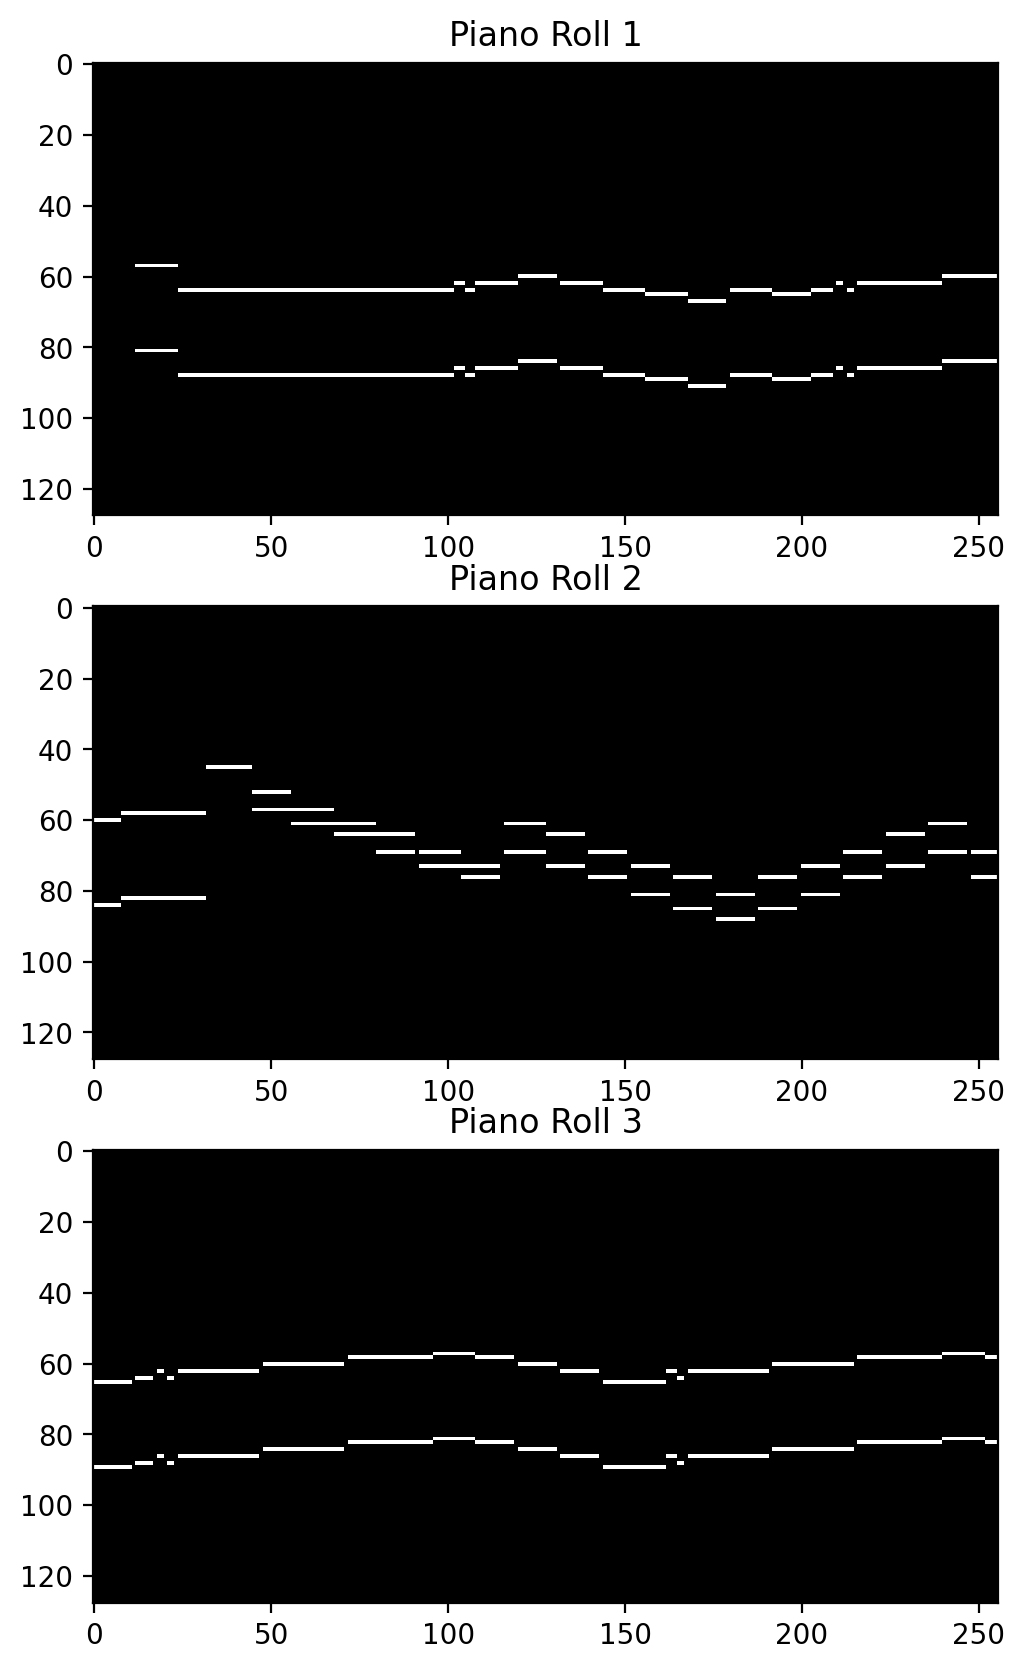

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(50, 10))

axs[0].imshow(np.transpose(piano_rolls[0]), cmap="gray")
axs[0].set_title("Piano Roll 1")

axs[1].imshow(np.transpose(piano_rolls[1]), cmap="gray")
axs[1].set_title("Piano Roll 2")

axs[2].imshow(np.transpose(piano_rolls[3]), cmap="gray")
axs[2].set_title("Piano Roll 3")

plt.show()

Сохранение и загрузка piano_rolls (Будет нужно для обучения и генерации)

In [20]:
np.save('input-data/piano_rolls/classical/piano_rolls_1000.npy', piano_rolls)

## Обратное преобразование сгенерированных piano roll

In [5]:
generated_piano_rolls = np.load('generated/piano_rolls/generate_track.npy', allow_pickle=True)
#Делаем громкость максимальной
generated_piano_rolls = generated_piano_rolls*127

In [16]:
generated_piano_rolls = generated_piano_rolls.reshape((10, 256, 128))

In [17]:
midi = pianoroll_to_midi(generated_piano_rolls, "generated/tmp/example_out.mid")

Увеличение темпа (преобразование в piano roll, почти в два раза замедляет midi)

In [13]:
files_path = "generated/tmp/*.mid"
for file, i in zip(glob.glob(files_path), range(len(glob.glob(files_path)))):
    mid = mido.MidiFile(file)

    new_tempo = mido.bpm2tempo(240)
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'set_tempo':
                msg.tempo = new_tempo

    mid.save("generated/tmp/speedup_example_out_" + str(i) + ".mid")
